In [5]:
import os
import logging
import sys

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import datasets, transforms
from torchvision.models import alexnet
from torchvision.models import resnet18
from torchvision.models import vgg11

from PIL import Image
from tqdm import tqdm

In [6]:
device = 'cuda' 
num_class = 101 
batch_size = 256    
num_epochs = 20     
step_size =  6     

In [7]:
def imgshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    return

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionando as imagens para 224x224
    transforms.ToTensor(),
])

caltech101_dataset = datasets.Caltech101(
    root='C:/Users/Usuário/Desktop/machine/Trabalho_3',    # Diretório onde o dataset será armazenado
    download=True,        # Baixar o dataset
    transform=transform   # Aplicar transformações
)

Files already downloaded and verified


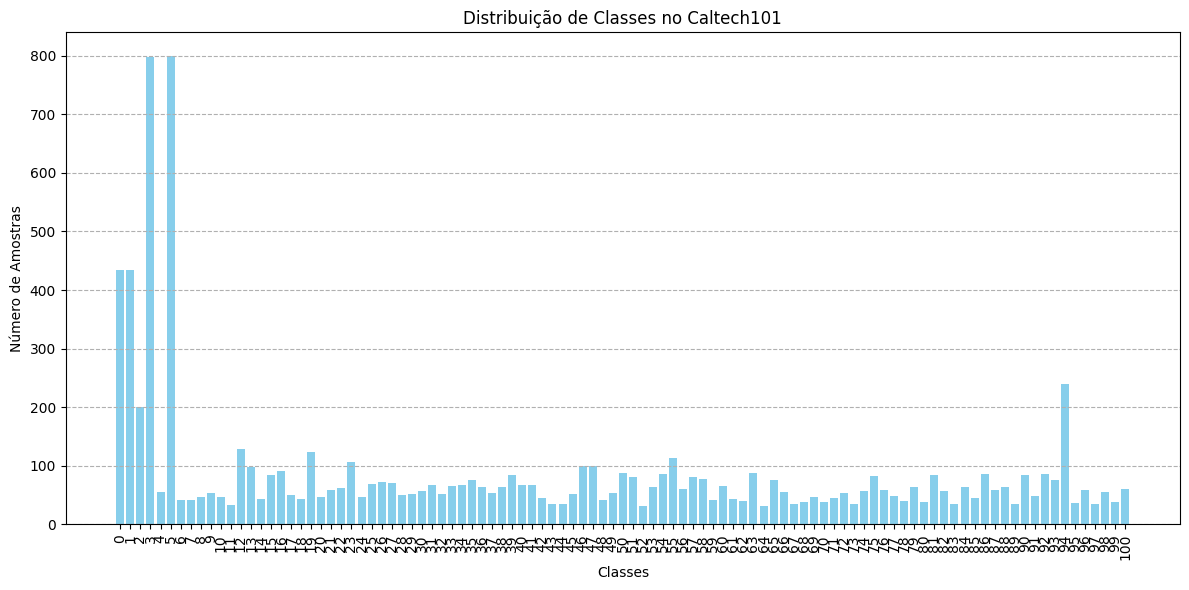

In [22]:
from collections import Counter

# Acessar os rótulos das classes
class_labels = [label for _, label in caltech101_dataset]

# Contar amostras por classe
class_counts = Counter(class_labels)

# Preparar os dados para o gráfico
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Número de Amostras')
plt.title('Distribuição de Classes no Caltech101')
plt.xticks(classes)  # Adiciona os rótulos das classes
plt.xticks(rotation=90)  # Rotaciona os rótulos para melhor visualização
plt.grid(axis='y', linestyle='--')
plt.tight_layout()  # Ajusta o layout
plt.show()

In [9]:
data_dir = 'C:/Users/Usuário/Desktop/machine/Trabalho_3/caltech101/101_ObjectCategories'

from torch.utils.data import random_split

dataset_size = len(caltech101_dataset)  # Tamanho total do dataset

train_size = int(0.8 * dataset_size)  # 80% para treino
val_size = int(0.1 * dataset_size)    # 10% para validação
test_size = dataset_size - train_size - val_size  # O restante para teste (10%)

# Dividindo o dataset completo em treino, validação e teste
train_dataset, val_dataset, test_dataset = random_split(caltech101_dataset, [train_size, val_size, test_size])

print(f'Tamanho do treino: {len(train_dataset)}')
print(f'Tamanho da validação: {len(val_dataset)}')
print(f'Tamanho do teste: {len(test_dataset)}')

Tamanho do treino: 6941
Tamanho da validação: 867
Tamanho do teste: 869


In [10]:
def custom_collate_fn(batch):
    for i in range(len(batch)):
        if batch[i][0].size(0) == 1:  # Verifica se a imagem tem 1 canal
            batch[i] = (batch[i][0].repeat(3, 1, 1), batch[i][1]) 
    return torch.utils.data.dataloader.default_collate(batch)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=custom_collate_fn, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=0)

In [ ]:
class Caltech101CNN(nn.Module):
    def __init__(self, num_classes=101):
        super(Caltech101CNN, self).__init__()

        # Camadas: Conv -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Camada 3: Conv -> ReLU -> MaxPool
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Camada 4: Conv -> ReLU -> MaxPool
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Camadas densas (Fully Connected)
        self.fc1 = nn.Linear(512 * 14 * 14, 4096) 
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # Passar pelas camadas convolucionais e de pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))

        x = x.view(-1, 512 * 14 * 14)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))

        x = self.fc3(x)
        return x

In [12]:
class Caltech101(nn.Module):
    def __init__(self, num_classes=102):  # 101 classes para o Caltech101
        super(Caltech101, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),  # Saída ajustada para 101 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [13]:
from sklearn.metrics import classification_report

def classification_report_per_class(outputs, labels):
    return classification_report(labels.cpu(), outputs.cpu(), zero_division=0)

In [14]:
import random

# Definindo a seed
seed = 42
random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  # Para garantir que os resultados sejam determinísticos
torch.backends.cudnn.benchmark = False  

epoch_loss_train = []
epoch_loss_val = []
epoch_acc_val = []
epoch_acc_train = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instanciar o modelo
model = Caltech101().to(device)

# Definir a função de perda e o otimizador
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

for epoch in range(20):  # 20 épocas
    model.train()
    running_loss_train = 0.0
    running_corrects_train = 0

    for inputs, labels in train_dataloader:  
        inputs, labels = inputs.to(device), labels.to(device) 
        optimizer.zero_grad() 

        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Estatísticas
        running_loss_train += loss.item() * inputs.size(0) 
        running_corrects_train += (torch.max(outputs, 1)[1] == labels).sum().item()

    epoch_loss_train.append(running_loss_train / len(train_dataloader.dataset))
    epoch_acc_train.append(running_corrects_train / len(train_dataloader.dataset))

    model.eval()
    running_loss_val = 0.0
    running_corrects_val = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_dataloader: 
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) 
            loss = criterion(outputs, labels)
            all_preds.append(preds)
            all_labels.append(labels)

            # Estatísticas
            running_loss_val += loss.item() * inputs.size(0) 
            running_corrects_val += (torch.max(outputs, 1)[1] == labels).sum().item()

    epoch_loss_val.append(running_loss_val / len(val_dataloader.dataset))
    epoch_acc_val.append(running_corrects_val / len(val_dataloader.dataset))
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    print(f"Época {epoch+1}/20")
    print(f"  Treino - Loss: {epoch_loss_train[-1]:.4f}, Acurácia: {epoch_acc_train[-1]:.4f}")
    print(f"  Validação - Loss: {epoch_loss_val[-1]:.4f}, Acurácia: {epoch_acc_val[-1]:.4f}")

Época 1/20
  Treino - Loss: 4.4423, Acurácia: 0.0903
  Validação - Loss: 4.1228, Acurácia: 0.1038
Época 2/20
  Treino - Loss: 3.9845, Acurácia: 0.1467
  Validação - Loss: 3.8309, Acurácia: 0.1742
Época 3/20
  Treino - Loss: 3.7339, Acurácia: 0.1781
  Validação - Loss: 3.5752, Acurácia: 0.1995
Época 4/20
  Treino - Loss: 3.4940, Acurácia: 0.2268
  Validação - Loss: 3.3938, Acurácia: 0.2434
Época 5/20
  Treino - Loss: 3.3349, Acurácia: 0.2651
  Validação - Loss: 3.2260, Acurácia: 0.3057
Época 6/20
  Treino - Loss: 3.0159, Acurácia: 0.3282
  Validação - Loss: 2.8422, Acurácia: 0.3656
Época 7/20
  Treino - Loss: 2.7117, Acurácia: 0.3752
  Validação - Loss: 2.6577, Acurácia: 0.4141
Época 8/20
  Treino - Loss: 2.5738, Acurácia: 0.4061
  Validação - Loss: 2.4509, Acurácia: 0.4429
Época 9/20
  Treino - Loss: 2.3133, Acurácia: 0.4427
  Validação - Loss: 2.2233, Acurácia: 0.4937
Época 10/20
  Treino - Loss: 2.1311, Acurácia: 0.4809
  Validação - Loss: 2.1870, Acurácia: 0.4994
Época 11/20
  Trein

In [15]:
print(classification_report_per_class(all_preds, all_labels))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        40
           1       0.94      0.97      0.96        33
           2       0.86      0.86      0.86        21
           3       0.97      1.00      0.98        88
           4       0.71      1.00      0.83         5
           5       0.91      0.98      0.94        81
           6       1.00      0.33      0.50         3
           7       0.17      0.20      0.18         5
           8       0.00      0.00      0.00         3
           9       0.33      0.33      0.33         6
          10       0.00      0.00      0.00         1
          11       0.67      0.50      0.57         4
          12       0.60      0.40      0.48        15
          13       0.35      0.86      0.50         7
          14       0.25      0.25      0.25         4
          15       0.78      0.64      0.70        11
          16       0.00      0.00      0.00         7
          17       0.00    

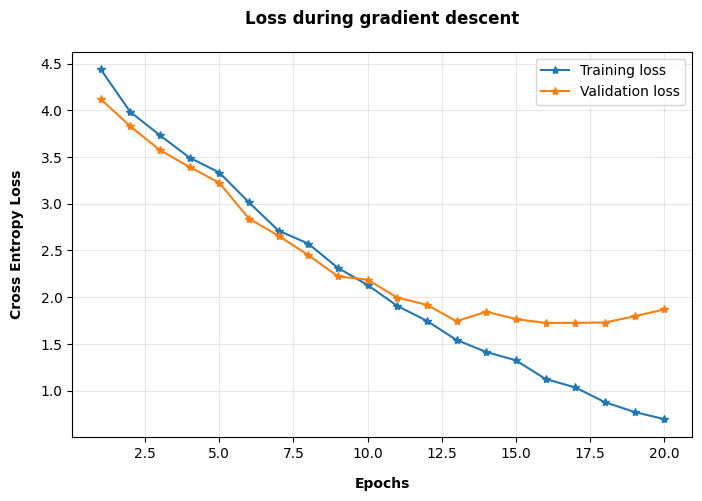

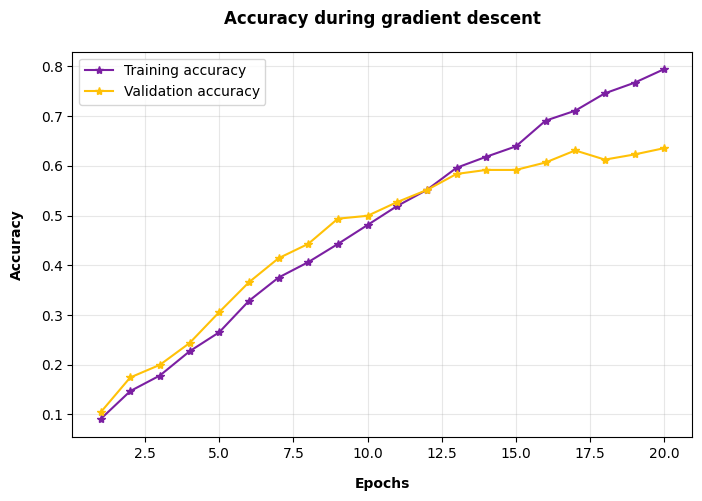

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, num_epochs+1)]
ax.plot(epochs, epoch_loss_train, linestyle='-', marker='*', label='Training loss')
ax.plot(epochs, epoch_loss_val, linestyle='-', marker='*', label='Validation loss')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Cross Entropy Loss', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Loss during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, num_epochs+1)]
ax.plot(epochs, epoch_acc_train, color='#7B1FA2', linestyle='-', marker='*', label='Training accuracy')
ax.plot(epochs, epoch_acc_val, color='#FFC107', linestyle='-', marker='*', label='Validation accuracy')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Accuracy', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Accuracy during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

def precision(outputs, labels):
    return precision_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0)

def recall(outputs, labels):
    return recall_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0)

def f1(outputs, labels):
    return f1_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0)

In [18]:
def evaluate_on_test(model, test_dataloader, device):
    model.eval()  # Colocar o modelo em modo de avaliação
    test_running_loss = 0.0
    test_running_corrects = 0
    all_preds = []
    all_labels = []

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():  
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Predições
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
            all_labels.append(labels)
            
            test_running_loss += loss.item() * inputs.size(0)
            test_running_corrects += (preds == labels).sum().item()

    test_loss = test_running_loss / len(test_dataloader.dataset)
    test_acc = test_running_corrects / len(test_dataloader.dataset)

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    test_precision = precision(all_preds, all_labels)
    test_recall = recall(all_preds, all_labels)
    test_f1 = f1(all_preds, all_labels)

    print(f"Teste - Loss: {test_loss:.4f}, Acurácia: {test_acc:.4f}")
    print(f"Precisão: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

    return test_loss, test_acc, test_precision, test_recall, test_f1

In [19]:
test_loss, test_acc, test_precision, test_recall, test_f1 = evaluate_on_test(model, test_dataloader, device)

Teste - Loss: 1.9184, Acurácia: 0.6145
Precisão: 0.6374, Recall: 0.6145, F1-Score: 0.6077


In [20]:
def count_zero_precision_recall(y_true, y_pred, num_classes=101):
    precision = []
    recall = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for class_label in range(num_classes):
        precision_value = precision_score(y_true, y_pred, labels=[class_label], average='macro', zero_division=0)
        recall_value = recall_score(y_true, y_pred, labels=[class_label], average='macro', zero_division=0)
        precision.append(precision_value)
        recall.append(recall_value)

    precision = np.array(precision)
    recall = np.array(recall)

    zero_precision_classes = [i for i in range(num_classes) if precision[i] == 0]
    zero_recall_classes = [i for i in range(num_classes) if recall[i] == 0]
    
    print(f"Número de classes com Precision = 0: {len(zero_precision_classes)}")
    print(f"Classes com Precision = 0: {zero_precision_classes}")

    print(f"Número de classes com Recall = 0: {len(zero_recall_classes)}")
    print(f"Classes com Recall = 0: {zero_recall_classes}")

    zero_classes = set(zero_precision_classes) & set(zero_recall_classes)
    print(f"Número de classes com Precision e Recall = 0: {len(zero_classes)}")
    print(f"Classes com Precision e Recall = 0: {zero_classes}")
    
count_zero_precision_recall(all_labels.cpu(),all_preds.cpu(), num_classes=101)

Número de classes com Precision = 0: 17
Classes com Precision = 0: [8, 10, 16, 17, 18, 26, 59, 60, 62, 66, 67, 68, 73, 79, 82, 89, 97]
Número de classes com Recall = 0: 17
Classes com Recall = 0: [8, 10, 16, 17, 18, 26, 59, 60, 62, 66, 67, 68, 73, 79, 82, 89, 97]
Número de classes com Precision e Recall = 0: 17
Classes com Precision e Recall = 0: {97, 66, 67, 68, 8, 73, 10, 79, 16, 17, 18, 82, 89, 26, 59, 60, 62}
